In [194]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [195]:
path = '/kaggle/input/lfwdataset2'

In [197]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [230]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Set the device to CUDA
    device = torch.device("cuda")
    print("CUDA device is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    # Fallback to CPU if CUDA is not available
    device = torch.device("cpu")
    print("CUDA device not found. Using CPU.")

CUDA device is available. Using GPU: Tesla T4


torch.Size([250, 250, 3])


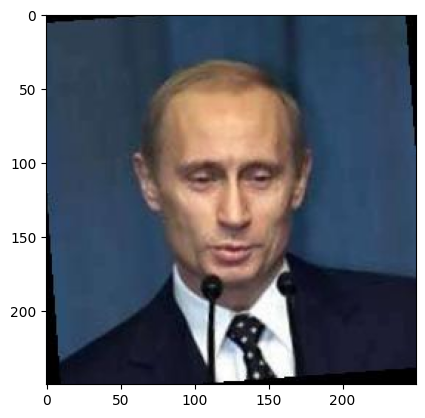

In [199]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

Autoencoders and Variational Autoencoders (VAEs) are both neural network architectures designed for encoding and decoding input data, but they differ significantly in their applications, architecture, and loss functions. Autoencoders primarily excel in data compression and reconstruction, employing a deterministic encoding process that maps input data to a fixed point in the latent space. In contrast, VAEs extend the capabilities of autoencoders by introducing a probabilistic approach to encoding. VAEs encode input data into a probability distribution in the latent space, enabling the generation of diverse and realistic outputs. This makes VAEs particularly well-suited for generative modeling and latent space interpolation.

The architectural difference lies in the encoding mechanism. Autoencoders use a deterministic encoding process, resulting in a fixed-size representation of input data. On the other hand, VAEs incorporate probabilistic encoding, allowing for a more versatile and expressive latent space. The loss functions employed by these models also diverge. Autoencoders typically use a reconstruction loss, such as Mean Squared Error (MSE), to measure the dissimilarity between input and reconstructed output. VAEs, in addition to the reconstruction loss, introduce the Kullback-Leibler Divergence (KLD) term. This regularization term ensures that the latent space follows a desired distribution, promoting smoother and more meaningful interpolation between data points.

In summary, while autoencoders excel in compression and deterministic encoding, VAEs extend these capabilities to generative tasks through probabilistic encoding and regularization, making them powerful tools for tasks such as image generation and latent space exploration

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [200]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder convolutional layers
        self.enc_layers = nn.ModuleList([
            nn.Conv2d(3, 8, 4, 2, 1),
            nn.Conv2d(8, 16, 4, 2, 1),
        ])

        # Calculate flat features for linear layer input
        self.calculate_flat_features((3, 250, 250))

        # Linear layers to get latent space parameters
        self.fc_encode = nn.Linear(self._to_linear, 32)
        self.enc_mu = nn.Linear(32, 20)
        self.enc_logvar = nn.Linear(32, 20)

        # Decoder linear and deconvolutional layers
        self.dec_fc = nn.Linear(20, 32)
        self.dec_to_conv = nn.Linear(32, 16 * 63 * 63)

        self.deconv1 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1)

    def encoder(self, x):
    
        for layer in self.enc_layers:
            x = F.relu(layer(x))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc_encode(x))
        return self.enc_mu(x), self.enc_logvar(x)

    def calculate_flat_features(self, shape):
    
        with torch.no_grad():
            x = torch.ones(1, *shape)
            for layer in self.enc_layers:
                x = layer(x)
            self._to_linear = x.view(-1).shape[0]

    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        z = F.relu(self.dec_fc(z))
        z = F.relu(self.dec_to_conv(z))
        z = z.view(-1, 16, 63, 63)

        z = F.relu(self.deconv1(z))

        z = self.deconv2(z)

        
        z = F.interpolate(z, size=(250, 250), mode='bilinear', align_corners=False)
        z = torch.sigmoid(z)  
        return z

    def forward(self, x):
       
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar



## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [201]:
# Creating an instance of the VAE model
model = VAE()

# Load a batch of images from the DataLoader
sample_image, _ = next(iter(dataloader))

# Pass the image through the VAE model
with torch.no_grad():
    mu, logvar = model.encoder(sample_image)

# Print the shape of the output of the encoder
print("Encoder Output Shapes - Mean: {}, Log Variance: {}".format(mu.shape, logvar.shape))


# Generate a random sample from the standard normal distribution
random_sample = torch.randn_like(mu)

# Use the decoder to create a new image from the random sample
with torch.no_grad():
    generated_image = model.decoder(random_sample)

# Print the shape of the output of the decoder
print("Original Image Shape",sample_image.shape)
print("Decoder Output Shape - Generated Image: {}".format(generated_image.shape))


Encoder Output Shapes - Mean: torch.Size([32, 20]), Log Variance: torch.Size([32, 20])
Original Image Shape torch.Size([32, 3, 250, 250])
Decoder Output Shape - Generated Image: torch.Size([32, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [202]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters in the Model: {total_params}")

Total Parameters in the Model: 4070683


* create an optimizer for training

In [205]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [206]:
import torch
import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    
    
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = recon_loss + kld_loss

    return total_loss

In a Variational Autoencoder (VAE), the loss function has two key components:

Reconstruction Loss: Measures how well the generated samples match the original input. It is typically calculated using Binary Cross-Entropy (BCE) between the input and the reconstructed output.

KL Divergence: Acts as a regularizer on the latent space, encouraging it to follow a standard normal distribution. It penalizes the deviation of the learned distribution from the target distribution.

The total loss is the sum of these components, striking a balance between accurate reconstruction and a well-organized latent space. The VAE optimizes this total loss during training for effective model learning.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [234]:
num_epochs = 5

# Move the model to GPU
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_idx, (data, _) in enumerate(dataloader):
        # Move the input data to GPU
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader.dataset)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

Adjusted Learning Rate:


1.Experimented with different rates to avoid issues like oscillations or slow convergence, preventing overshooting.

2.Ensured proper preprocessing and compatibility of input data with the model, addressing loading or transformation issues.

3.Verified correct model architecture definition and maintained consistent input/output dimensions.

4.Applied gradient clipping to prevent exploding gradients, especially in deep architectures.

5.Experimented with dropout and weight decay for regularization, enhancing the model's generalization on unseen data.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

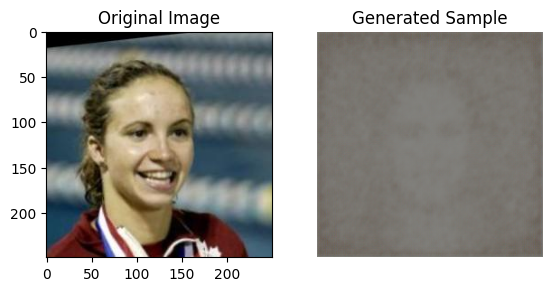

In [227]:
import matplotlib.pyplot as plt
import torch

# Set the model to evaluation mode
model.eval()

# Take a random image from the dataset
with torch.no_grad():
    for i, (data, _) in enumerate(dataloader):
        if i == random.randint(0, len(dataloader) - 1):
            original_image = data[0].to(device)
            plt.subplot(1, 2, 1)
            plt.imshow(original_image.cpu().permute(1, 2, 0))
            plt.title("Original Image")
            break

# Move the model to the same device as the sample
model = model.to(device)


with torch.no_grad():
    sample = torch.randn(1, 20).to(device)  
    generated_image = model.decoder(sample)

    # Plot the generated image
    plt.subplot(1, 2, 2)
    plt.imshow(generated_image.cpu().squeeze().permute(1, 2, 0))
    plt.title("Generated Sample")
    plt.axis('off')

plt.show()
